In [1]:
import pandas as pd
import wandb
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import json
import numpy as np

api = wandb.Api()
entity = "magalhaes"
project = "Audio"

runs = api.runs(f"{entity}/{project}")

In [2]:
summary_list, config_list, name_list = [], [], []
for run in runs:
    if ("Precomputed_Spec_MData" in run.name and "split" not in run.name):
        # .summary contains output keys/values for
        # metrics such as accuracy.
        #  We call ._json_dict to omit large files
        summary_dict = run.summary._json_dict


        # if run is not finished, skip
        if run.state != "finished":
            continue

        # Add the run's id
        summary_dict['run_id'] = run.id
        

        logged_artifacts = run.logged_artifacts()
        
        for artifact in logged_artifacts:
            # Check if artifact.name contains CrossValResultsTable
            # ALERT: This will not download new data if directories exist, manually delete them to refresh
            if "CrossValResultsTable" in artifact.name and "Schreder" not in artifact.name:
                    root = f"../wandb_dump_data/run-{run.name}"
                    # If the dir "root" exists, skip
                    if not os.path.isdir(root):
                        artifact.download(root=f"../wandb_dump_data/run-{run.name}")

                    # Read the json file downloaded into a dataframe
                    json_data = json.load(open(f"../wandb_dump_data/run-{run.name}/Cross Val Results Table.table.json"))

                    # Convert the json file into a dataframe
                    table_df = pd.DataFrame(json_data['data'], columns=json_data['columns'])

        # .name is the human-readable name of the run.
        name_list.append(run.name)


        # Set f1-score, accuracy, precision, recall in the summary_dict from the table_df, from the "all" class
        summary_dict['F1 score'] = table_df.loc[table_df['Class'] == 'all']['F1-score'].values[0]
        summary_dict['Precision'] = table_df.loc[table_df['Class'] == 'all']['Precision'].values[0]
        summary_dict['Recall'] = table_df.loc[table_df['Class'] == 'all']['Recall'].values[0]

        # Store metrics for other classes
        classes_data = {}
        for index, row in table_df.iterrows():
            class_name = row['Class']
            if class_name != 'all':
                classes_data[class_name] = {
                    'F1 score': row['F1-score'],
                    'Precision': row['Precision'],
                    'Recall': row['Recall']
                }
        
        summary_dict['classes_data'] = classes_data
        summary_list.append(summary_dict)

summary_df = pd.DataFrame.from_records(summary_list)

summary_df['name'] = name_list

# Remove the rows with no "Cross Val Results Table"
summary_df = summary_df[summary_df['Cross Val Results Table'].notna()]


# FIlter summary_df to only include rows with "name" containing "MData" and NOT containing "split"
summary_df = summary_df[summary_df['name'].str.contains("MData") & ~summary_df['name'].str.contains("split")]


# Remove "Precomputed_Spec_MData_" from "name" column
summary_df['name'] = summary_df['name'].str.replace("Precomputed_Spec_MData_P04", "")

# Remove "Precomputed_Spec_MData_" from "name" column
summary_df['name'] = summary_df['name'].str.replace("Precomputed_Spec_MData_", "")

# Run name is Precomputed_Spec_MData_{ExpName}_{Augmentation}_{RunID}, where RunID is a number. Eg Precomputed_Spec_MData_AddGaussianNoise0, Precomputed_Spec_MData_P04_AddGaussianNoise_Gain. If there is no ExpName, then the name is Precomputed_Spec_MData_{Augmentation}_{RunID}
# Possible augmentations are PitchShift, AddGaussianNoise, AirAbsorption, ClippingDistortion, Gain, LowPassFilter, Oversampler, BackgroundNoise, TimeStretch, Roll, TimeMasking, FreqMasking, SpecAugment
# Possible ExpNames are P04, Top7


# Expanding the nested dictionary into separate columns
classes_df = pd.json_normalize(summary_df['classes_data'])

# Renaming columns for clarity
columns = {}
for column in classes_df.columns:
    class_name, metric = column.split('.', 1)
    new_col_name = f"{class_name}_{metric}"
    columns[column] = new_col_name
classes_df = classes_df.rename(columns=columns)

# Concatenating the expanded columns to the original dataframe
summary_df = pd.concat([summary_df.drop(columns=['classes_data']), classes_df], axis=1)


# Separate the "name" into "Augmentation" and "RunID" where the "name" is NameOfAugmentationRunID, but RunID is a number. Eg AddGaussianNoise0
summary_df[['Augmentation', 'RunID']] = summary_df['name'].str.split('(?<=\D)(?=\d)', expand=True)

# # Remove the "name" column
# summary_df = summary_df.drop(columns=['name'])

print(summary_df.columns)

# List of basic columns
basic_columns = ["Augmentation", "RunID", "F1 score", "Recall", "Precision", "Accuracy"]

# List of class performance columns (dynamically generated based on the columns present in summary_df)
class_columns = [col for col in summary_df.columns if any(cls in col for cls in ['person_', 'bicycle_', 'car_', 'motorcycle_', 'siren_', 'bus_', 'truck_'])]

# Combining basic and class performance columns
final_columns = basic_columns + class_columns

# Selecting only those columns
summary_df = summary_df[final_columns]


# Sort by augmentation
summary_df = summary_df.sort_values(by=['Augmentation'], ascending=False)

# Sort by augmentation, then by f1-score
# summary_df = summary_df.sort_values(by=['Augmentation', 'F1 score'], ascending=False)

# Rename f1 score to F1Score
summary_df = summary_df.rename(columns={"F1 score": "F1-Score"})

# Remove the ids
summary_df = summary_df.reset_index(drop=True)

summary_df.to_csv("wandb_query.csv", index=False)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Index(['Expected Calibration Error Plot (Schreder data)', 'F1 score',
       'Cross Val Results Table', 'Reliability Diagram',
       'Schreder Cross Val Results Table', '_runtime', '_timestamp',
       'Test loss', 'Expected Calibration Error Plot',
       'Reliability Diagram (Schreder data)', 'Loss', 'Precision', '_wandb',
       'Accuracy', '_step', 'Recall', 'run_id', 'name', 'person_F1 score',
       'person_Precision', 'person_Recall', 'bicycle_F1 score',
       'bicycle_Precision', 'bicycle_Recall', 'car_F1 score', 'car_Precision',
       'car_Recall', 'motorcycle_F1 score', 'motorcycle_Precision',
       'motorcycle_Recall', 'siren_F1 score', 'siren_Precision',
       'siren_Recall', 'bus_F1 score', 'bus_Precision', 'bus_Recall',
       'truck_F1 score', 'truck_Precision', 'truck_Recall', 'Augmentation',
       'RunID'],
      dtype='object')


In [3]:
df = summary_df

# Calculate the difference in F1-Score compared to Base 0
base_f1_score = df[df["Augmentation"] == "Base"]["F1-Score"].values[0]
print(f"Base F1-Score: {base_f1_score}")

# Find the entry for Gain and RunID None
gain_f1_score = df[(df["Augmentation"] == "Gain") & (df["RunID"].isna())]["F1-Score"].values[0]

df["Difference"] = (df["F1-Score"] - base_f1_score) * 100

# Filter out rows with NaN values in the F1-Score
df = df[(df["Augmentation"] != "Base") & ~df["F1-Score"].isna()]

Base F1-Score: 0.563662847198044


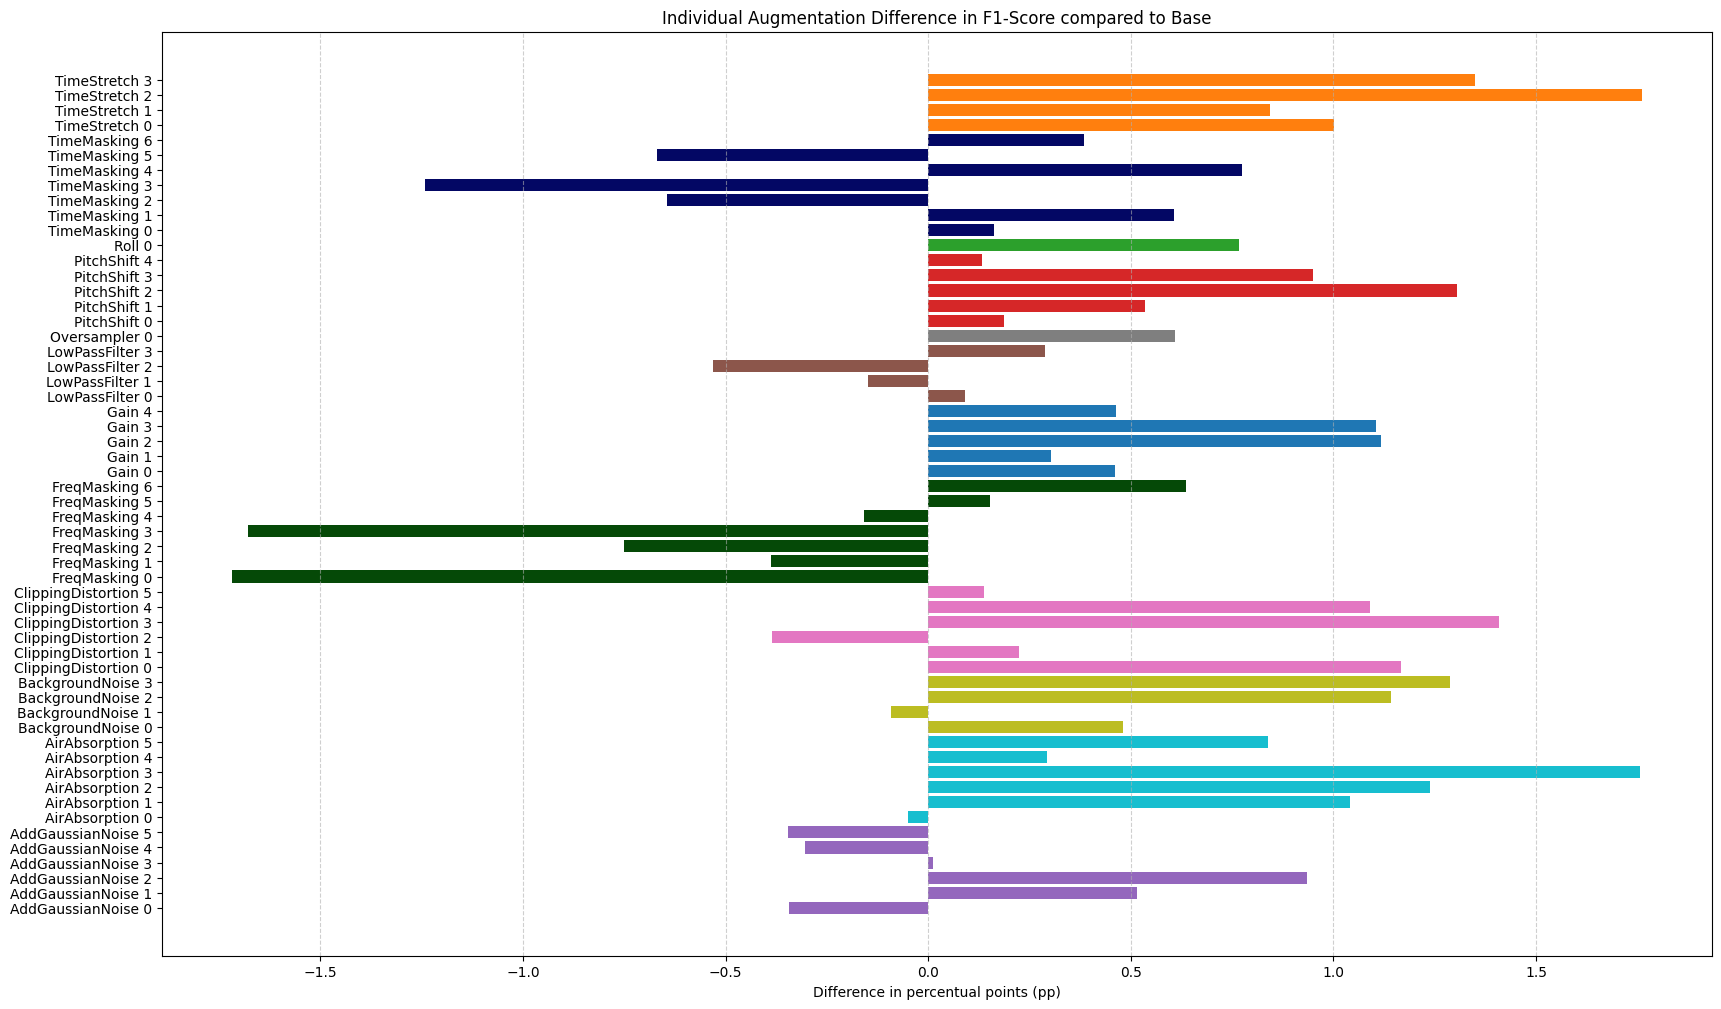

Number of runs: 57
AddGaussianNoise: 6
AirAbsorption: 6
BackgroundNoise: 4
ClippingDistortion: 6
FreqMasking: 7
Gain: 6
LowPassFilter: 4
Oversampler: 1
PitchShift: 5
Roll: 1
TimeMasking: 7
TimeStretch: 4


In [4]:

# Sort them alphabetically, then by runid
my_df = deepcopy(df.sort_values(by=["Augmentation", "RunID"]))

plt.figure(figsize=(20, 12))

# Create a dictionary to map each Augmentation to a unique color
color_map = {
    "Gain": "tab:blue",
    "TimeStretch": "tab:orange",
    "Roll": "tab:green",
    "PitchShift": "tab:red",
    "AddGaussianNoise": "tab:purple",
    "LowPassFilter": "tab:brown",
    "ClippingDistortion": "tab:pink",
    "Oversampler": "tab:gray",
    "BackgroundNoise": "tab:olive",
    "AirAbsorption": "tab:cyan",
    "TimeMasking": "xkcd:darkblue",
    "FreqMasking": "xkcd:darkgreen",
    "SpecAugment": "xkcd:darkred"
}


# Only plot the ones with "RunID" not none no 04 in the RunID
my_df = my_df[my_df["RunID"].isna() == False]
my_df = my_df[my_df["RunID"].str.contains("04") == False]
my_df = my_df[my_df["RunID"].str.contains("06") == False]
my_df = my_df[my_df["RunID"].str.contains("7_") == False]

# Change the difference of Oversampler to 0.61
my_df.loc[my_df["Augmentation"] == "Oversampler", "Difference"] = 0.61

for i, (augmentation, group) in enumerate(my_df.groupby("Augmentation")):
    color = color_map[augmentation]  # Get color from the dictionary
    plt.barh([augmentation + f" {run_id}" for run_id in group["RunID"]], group["Difference"], color=color, label=augmentation)

# Lower the y-axis label font size
plt.yticks(fontsize=10)

plt.xlabel('Difference in percentual points (pp)')
plt.title('Individual Augmentation Difference in F1-Score compared to Base')
plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.legend()

plt.show()

# print the number of runs
print(f"Number of runs: {len(my_df)}")

# print the number of runs per augmentation type
for augmentation, group in my_df.groupby("Augmentation"):
    print(f"{augmentation}: {len(group)}")

# Store the best run for each augmentation
best_runs = []

for augmentation, group in my_df.groupby("Augmentation"):
    best_run = group.sort_values(by="Difference", ascending=False).iloc[0]
    best_runs.append(best_run)

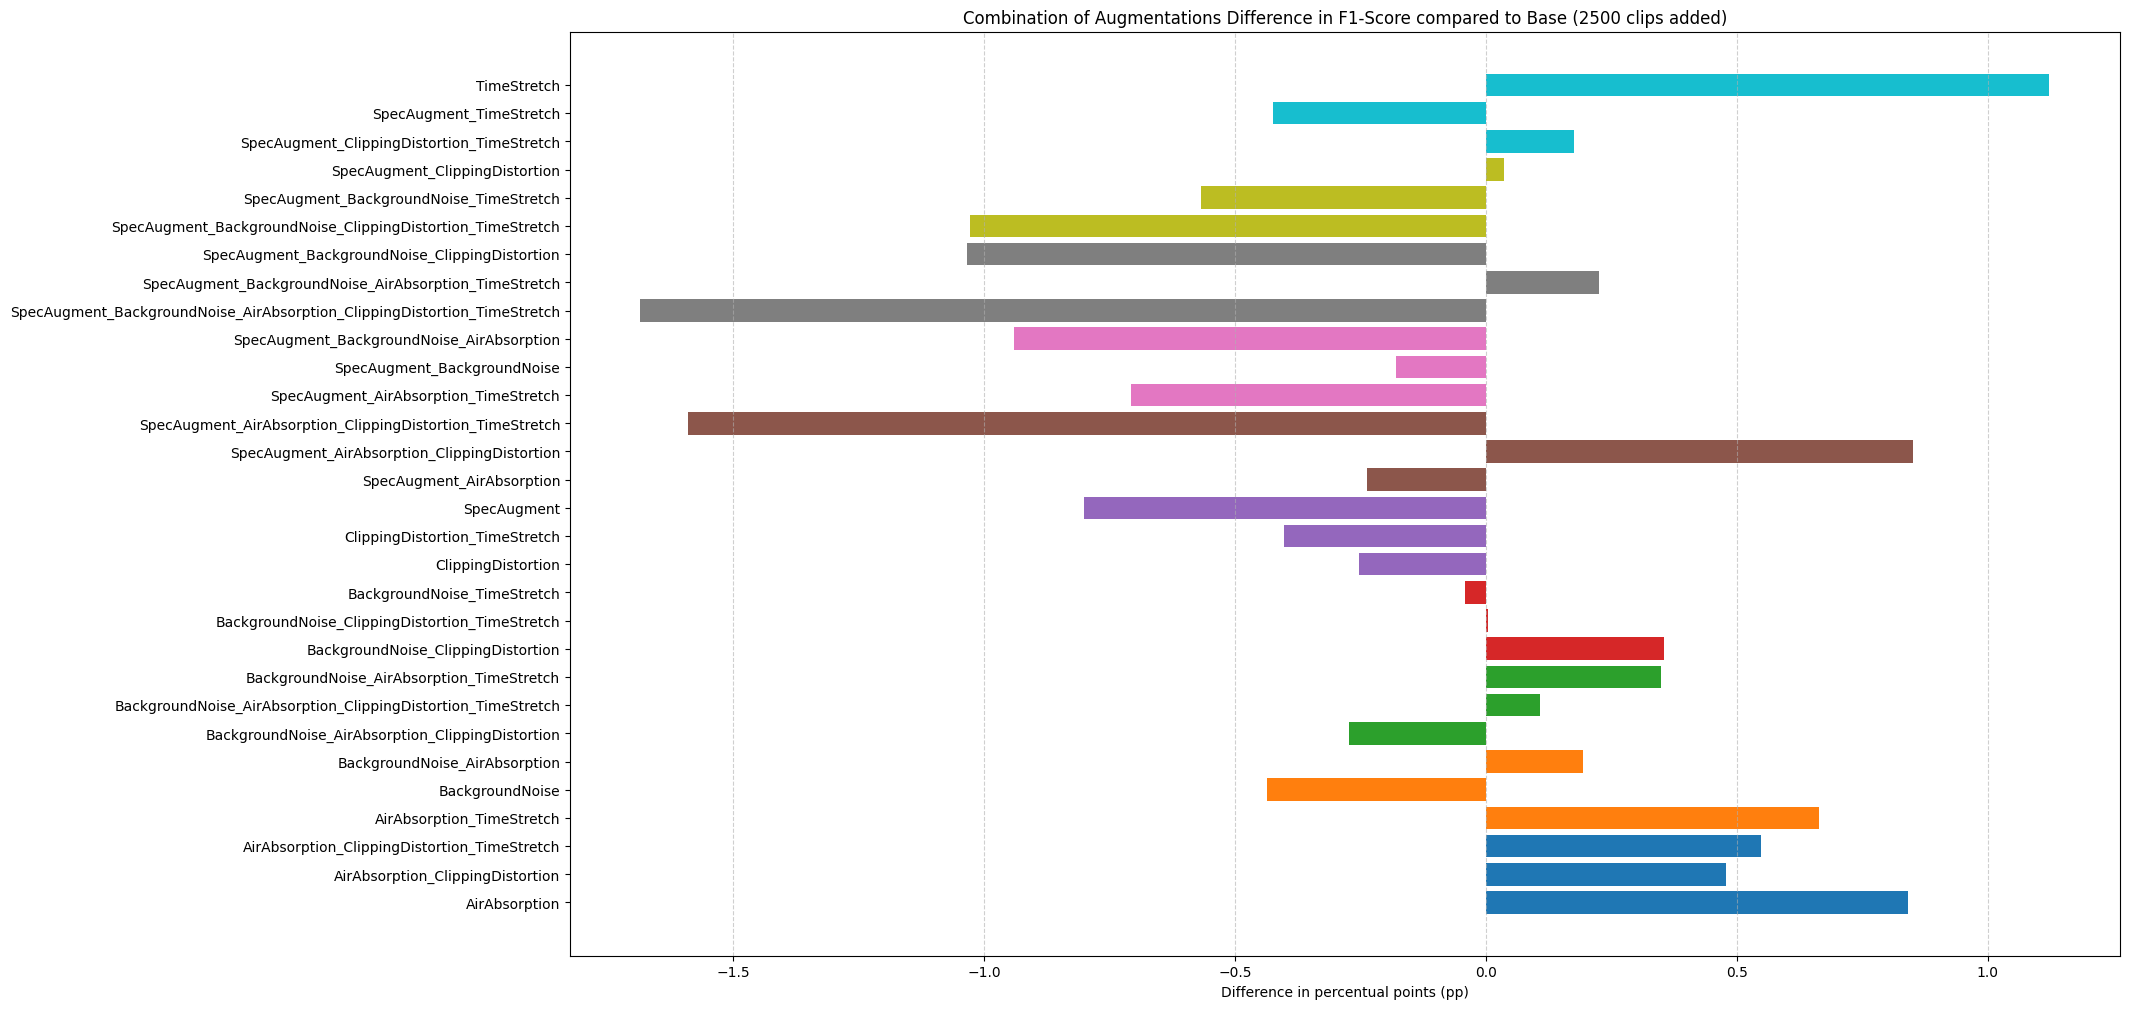

Amount of runs: 30


In [5]:

# Sort them alphabetically, then by runid
my_df = deepcopy(df.sort_values(by=["Augmentation", "RunID"]))

plt.figure(figsize=(20, 12))

my_df = my_df[my_df["RunID"].str.contains("7_") == True]

#Remove the leading 7_
my_df["RunID"] = my_df["RunID"].str.replace("7_", "")

# Create a dictionary to map each Augmentation to a unique color
unique_runids = my_df["RunID"].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_runids)))
color_map = dict(zip(unique_runids, colors))


# Sort them by runid size
my_df = my_df.sort_values(by=["RunID"])


for i, (runid, group) in enumerate(my_df.groupby("RunID")):
    color = color_map[runid]  # Get color from the dictionary
    plt.barh([f"{runid}" for runid in group["RunID"]], group["Difference"], color=color, label=runid)

# Lower the y-axis label font size
plt.yticks(fontsize=10)

plt.xlabel('Difference in percentual points (pp)')
plt.title('Combination of Augmentations Difference in F1-Score compared to Base (2500 clips added)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.legend()

plt.show()

# Print the amount of runs
print(f"Amount of runs: {len(my_df)}")

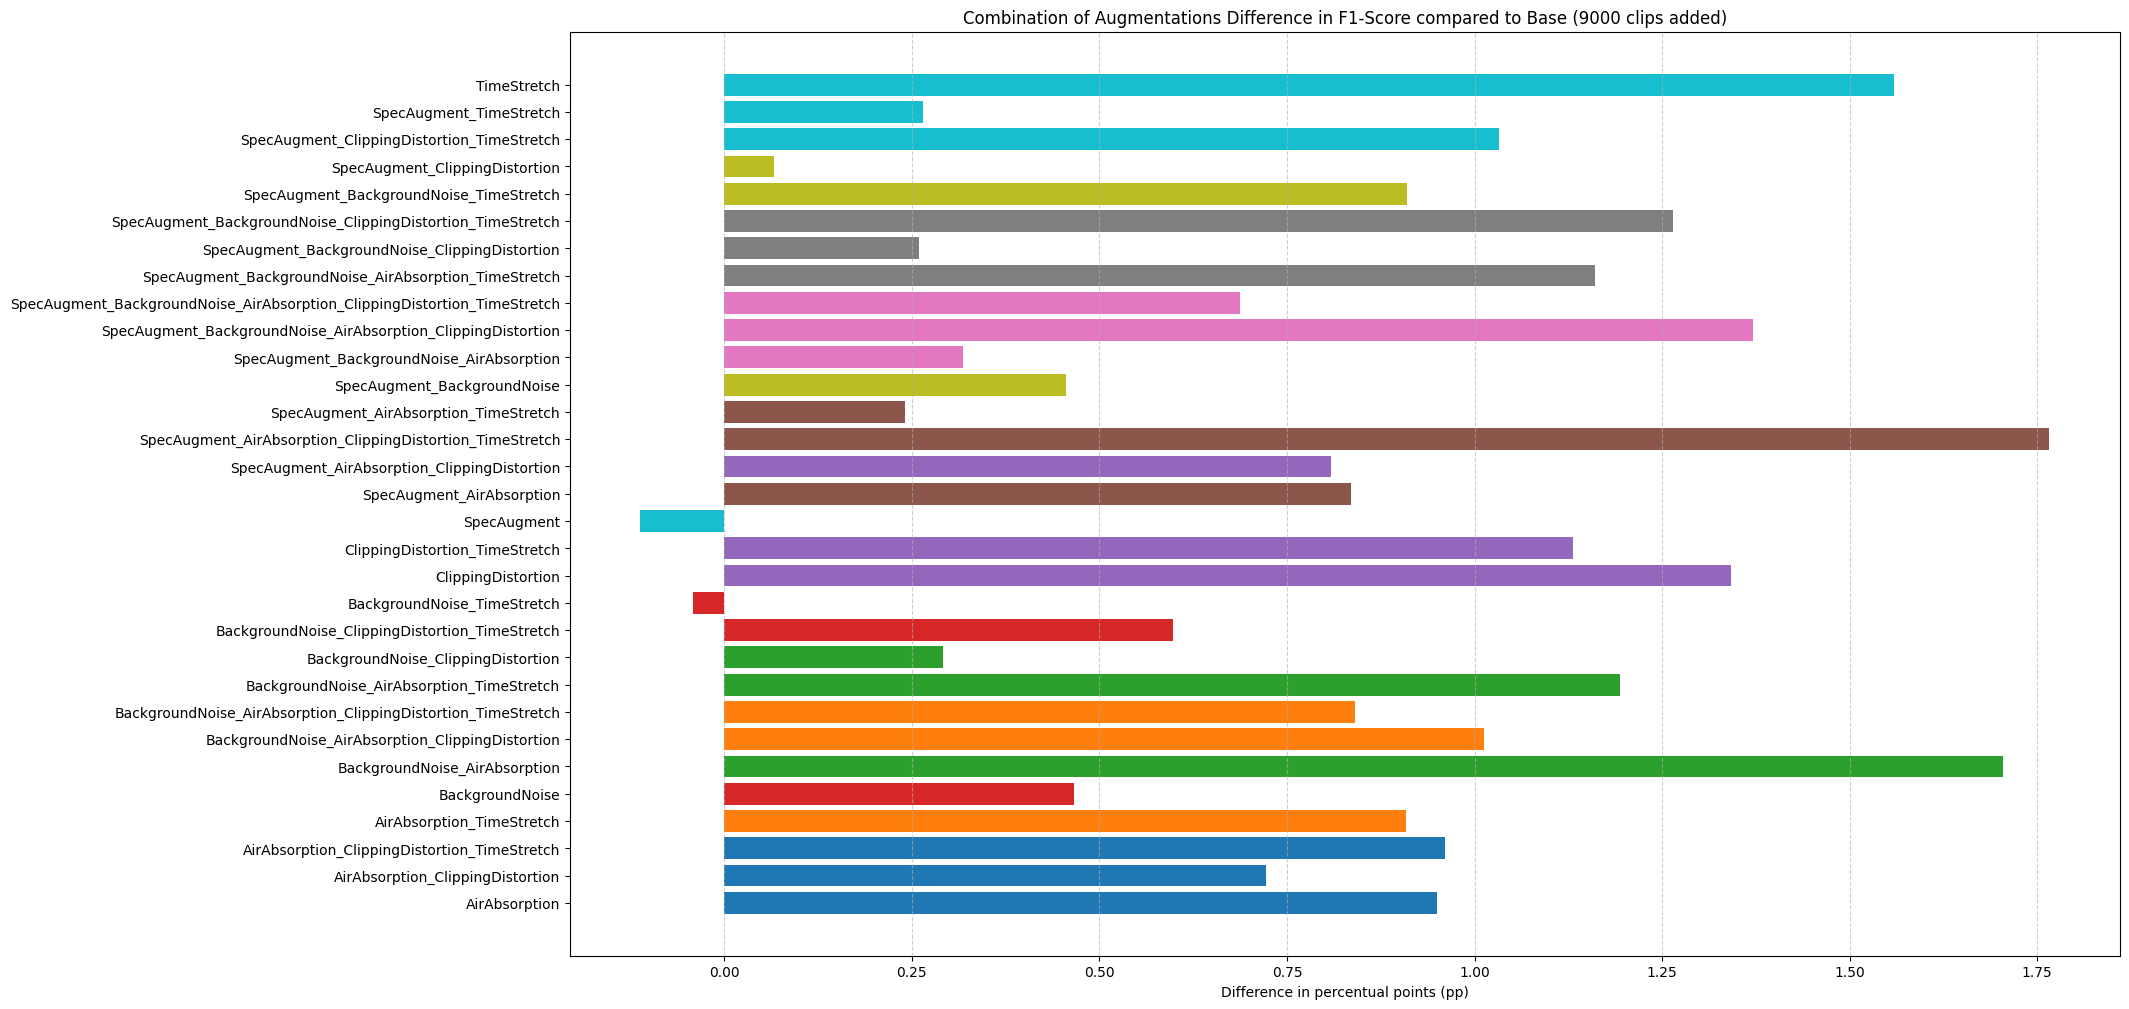

In [6]:
# Sort them alphabetically, then by runid
my_df = deepcopy(df.sort_values(by=["Augmentation", "RunID"]))

# Only plot the ones with "RunID" not none no 04 in the RunID
# my_df = my_df[my_df["RunID"].isna() == False]
my_df = my_df[my_df["RunID"].str.contains("04") == True]
# my_df = my_df[my_df["RunID"].str.contains("7_") == False]
plt.figure(figsize=(20, 12))

# Remove leading _ from augmentation
my_df["Augmentation"] = my_df["Augmentation"].str[1:]
my_df["Augmentation"] = my_df["Augmentation"].str[:-2]


# Create a dictionary to map each Augmentation to a unique color
unique_runids = my_df["Augmentation"].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_runids)))
color_map = dict(zip(unique_runids, colors))

# Change the difference of Oversampler to 0.61
my_df.loc[my_df["Augmentation"] == "Oversampler", "Difference"] = 0.61

for i, (augmentation, group) in enumerate(my_df.groupby("Augmentation")):
    color = color_map[augmentation]  # Get color from the dictionary
    plt.barh(augmentation, group["Difference"], color=color, label=augmentation)

# Lower the y-axis label font size
plt.yticks(fontsize=10)

plt.xlabel('Difference in percentual points (pp)')
plt.title('Combination of Augmentations Difference in F1-Score compared to Base (9000 clips added)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.legend()

plt.show()

   Augmentation                                              RunID  F1-Score  \
95            P                06_AirAbsorption_ClippingDistortion  0.584098   
96            P    06_AirAbsorption_ClippingDistortion_TimeStretch  0.571206   
97            P  06_SpecAugment_BackgroundNoise_ClippingDistort...  0.568016   

      Recall  Precision  Accuracy  person_F1 score  person_Precision  \
95  0.701821   0.551153  0.809815         0.930305          0.930851   
96  0.703664   0.510054  0.817848         0.931453          0.932735   
97  0.720528   0.505657  0.806854         0.930481          0.925218   

    person_Recall  bicycle_F1 score  ...  siren_F1 score  siren_Precision  \
95       0.929761          0.540470  ...        0.676789         0.587852   
96       0.930188          0.510514  ...        0.675666         0.589310   
97       0.935952          0.562842  ...        0.621211         0.514647   

    siren_Recall  bus_F1 score  bus_Precision  bus_Recall  truck_F1 score  \
95  

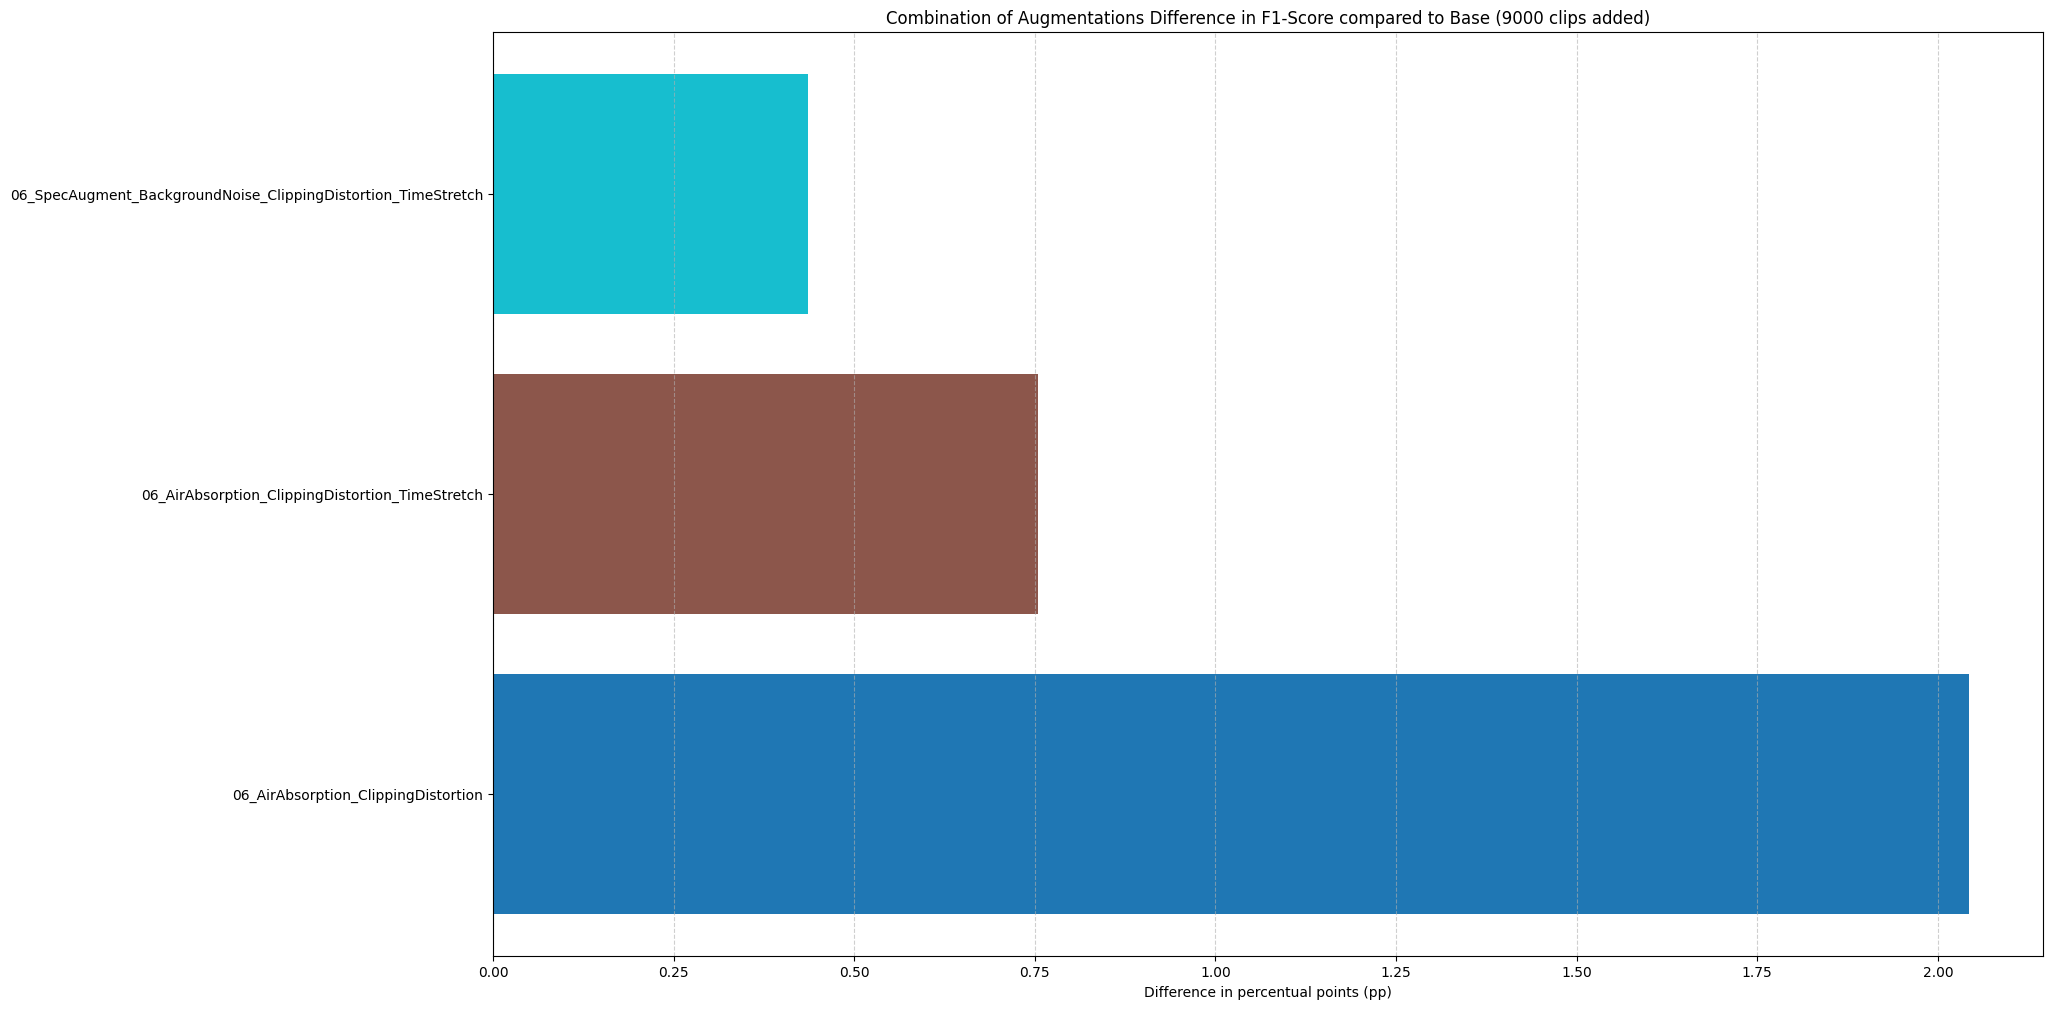

In [11]:
# Sort them alphabetically, then by runid
my_df = deepcopy(df.sort_values(by=["Augmentation", "RunID"]))

# Only plot the ones with "RunID" not none no 04 in the RunID
# my_df = my_df[my_df["RunID"].isna() == False]
my_df = my_df[my_df["RunID"].str.contains("06") == True]
print(my_df)
# my_df = my_df[my_df["RunID"].str.contains("7_") == False]
plt.figure(figsize=(20, 12))


# Create a dictionary to map each Augmentation to a unique color
unique_runids = my_df["RunID"].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_runids)))
color_map = dict(zip(unique_runids, colors))

# Print the "Difference" of every row
for index, row in my_df.iterrows():
    print(f"{row['Augmentation']}: {row['Difference']}")

for i, (runid, group) in enumerate(my_df.groupby("RunID")):
    color = color_map[runid]  # Get color from the dictionary
    plt.barh([f"{runid}" for runid in group["RunID"]], group["Difference"], color=color, label=runid)

# Lower the y-axis label font size
plt.yticks(fontsize=10)

plt.xlabel('Difference in percentual points (pp)')
plt.title('Combination of Augmentations Difference in F1-Score compared to Base (9000 clips added)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.legend()

plt.show()

In [ ]:
#Get the 5 best performing augmentations, one per type
best_augmentations = []
for augmentation, group in df.groupby("Augmentation"):
    best_augmentations.append(group.sort_values(by="Difference", ascending=False).iloc[0])

# SOrt by difference
best_augmentations = sorted(best_augmentations, key=lambda x: x["Difference"], reverse=True)

# Print the best augmentations
print("Best augmentations:")
for augmentation in best_augmentations:
    print(f"{augmentation['Augmentation']} {augmentation['RunID']} with a difference of {augmentation['Difference']}pp")

Best augmentations:
Oversampler 0 with a difference of 1.9099694024237612pp
_SpecAugment_AirAbsorption_ClippingDistortion_TimeStretch_P 04 with a difference of 1.7661726838434588pp
TimeStretch 2 with a difference of 1.7601795235149043pp
AirAbsorption 3 with a difference of 1.7560622702982087pp
_BackgroundNoise_AirAbsorption_P 04 with a difference of 1.7040247512358553pp
_TimeStretch_P 04 with a difference of 1.5591312257488221pp
ClippingDistortion 3 with a difference of 1.4084178216503984pp
_SpecAugment_BackgroundNoise_AirAbsorption_ClippingDistortion_P 04 with a difference of 1.370591426310519pp
_ClippingDistortion_P 04 with a difference of 1.3420274755079786pp
PitchShift 2 with a difference of 1.3038537296208297pp
AirAbsorption_Gain None with a difference of 1.2921336129155803pp
BackgroundNoise 3 with a difference of 1.287202775977847pp
_SpecAugment_BackgroundNoise_ClippingDistortion_TimeStretch_P 04 with a difference of 1.2646055639766507pp
_BackgroundNoise_AirAbsorption_TimeStretch